In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

dataset_url = "archive/Multi Cancer/data/Brain Cancer"
test_url = "archive/Multi Cancer/data/test"

data_dir = pathlib.Path(dataset_url).with_suffix('')
test_dir = pathlib.Path(test_url).with_suffix('')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count, test_count)

12750 2250


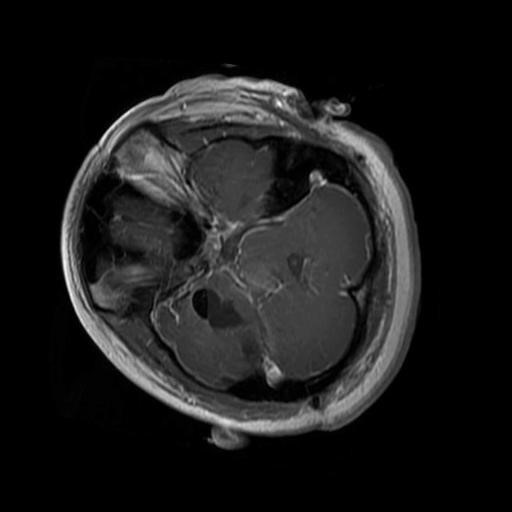

In [5]:
brain_glioma = list(data_dir.glob('brain_glioma/*'))
PIL.Image.open(str(brain_glioma[2]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12750 files belonging to 3 classes.
Using 10200 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12750 files belonging to 3 classes.
Using 2550 files for validation.


In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2250 files belonging to 3 classes.


In [10]:
class_names = train_ds.class_names
class_names

['brain_glioma', 'brain_menin', 'brain_tumor']

0
1
2
3
4
5
6
7
8


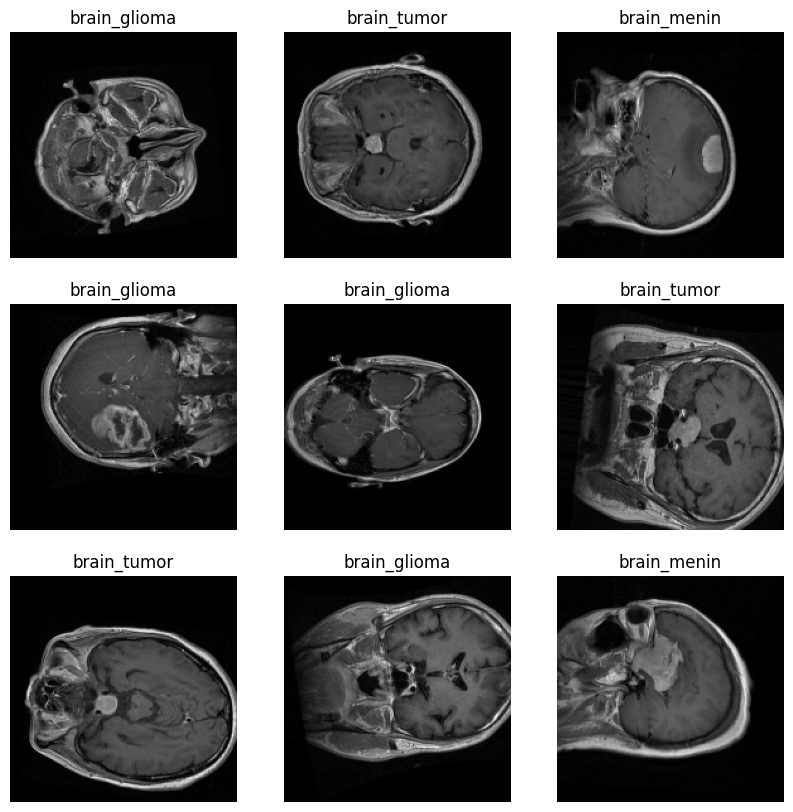

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(i)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
imported_model= tf.keras.applications.ResNet50(
    include_top=False, # False allows us to add custom input/output layers
    input_shape=(180,180,3),
    pooling='avg',classes=3,
    weights='imagenet')

for layer in imported_model.layers:
    layer.trainable=False

In [14]:
num_classes = len(class_names)

model = tf.keras.Sequential()
model.add(imported_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
epochs=100

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback],
)

Epoch 1/100
319/319 [==============================] - 20s 38ms/step - loss: 0.3179 - accuracy: 0.8912 - val_loss: 0.1525 - val_accuracy: 0.9427
Epoch 2/100
319/319 [==============================] - 11s 33ms/step - loss: 0.1239 - accuracy: 0.9522 - val_loss: 0.1020 - val_accuracy: 0.9624
Epoch 3/100
319/319 [==============================] - 10s 33ms/step - loss: 0.0923 - accuracy: 0.9653 - val_loss: 0.0751 - val_accuracy: 0.9710
Epoch 4/100
319/319 [==============================] - 10s 33ms/step - loss: 0.0699 - accuracy: 0.9747 - val_loss: 0.0802 - val_accuracy: 0.9682
Epoch 5/100
319/319 [==============================] - 11s 33ms/step - loss: 0.0588 - accuracy: 0.9785 - val_loss: 0.0725 - val_accuracy: 0.9714
Epoch 6/100
319/319 [==============================] - 11s 33ms/step - loss: 0.0449 - accuracy: 0.9832 - val_loss: 0.0946 - val_accuracy: 0.9659
Epoch 7/100
319/319 [==============================] - 11s 33ms/step - loss: 0.0325 - accuracy: 0.9868 - val_loss: 0.0382 - val_ac

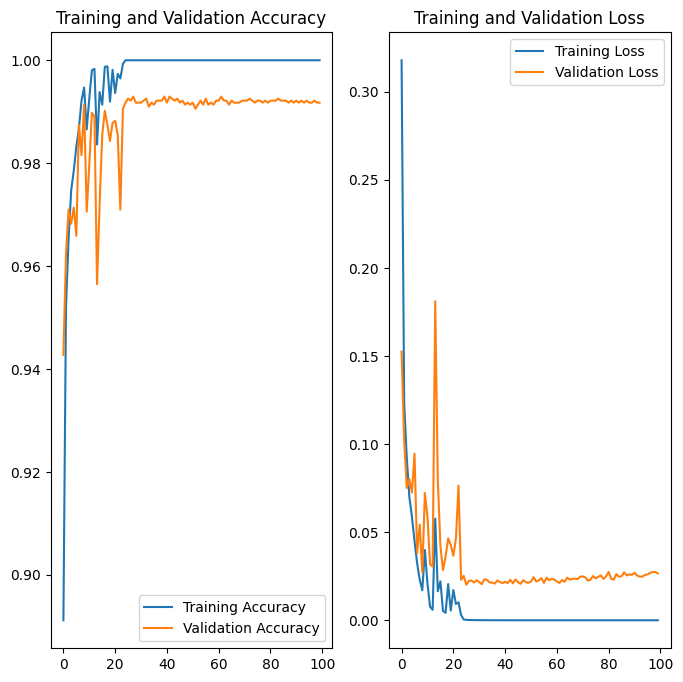

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:   
   y_true.append(label_batch.numpy())
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 760ms/step


In [19]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

71/71 [==============================] - 2s 31ms/step - loss: 0.0569 - accuracy: 0.9893
Test Loss: 0.0568709559738636
Test Accuracy: 0.9893333315849304


In [20]:
test_images, test_labels = next(iter(test_ds))
predictions = model.predict(test_images)

1/1 [==============================] - 0s 23ms/step


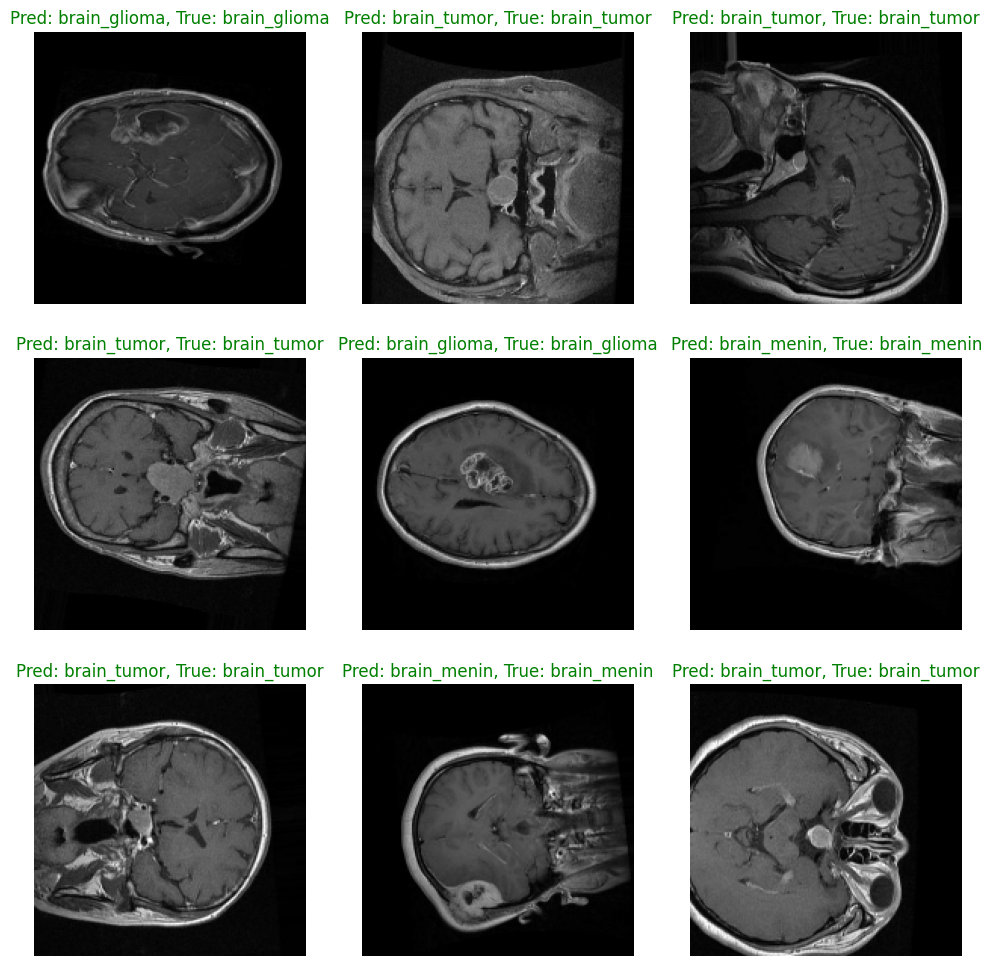

In [21]:
plt.figure(figsize=(12, 12))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    predicted_label = np.argmax(predictions[i])
    true_label = test_labels[i]

    text_color = 'green' if predicted_label == true_label else 'red'
    
    plt.title(f"Pred: {class_names[predicted_label]}, True: {class_names[true_label]}", color=text_color)
    plt.axis("off")
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[747,   3,   0],
       [  4, 737,   9],
       [  1,   7, 742]], dtype=int64)

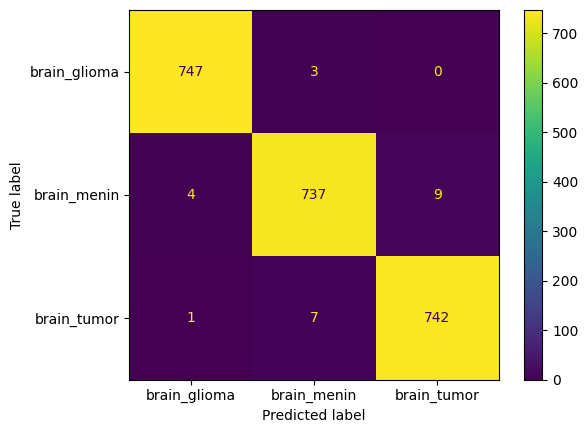

In [23]:
cm_disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_disp.plot()